In [68]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import jvp, yvp
from matplotlib import pyplot as plt
import sympy as sy

In [74]:
R = np.linspace(2.35, 3.35, 11)
data = [np.loadtxt("TL_Model_Perforated_Plate/%.2f.txt" %r, delimiter=",") for r in R]
D = 74.72e-3 # distance from the port to the FR4 layer
D = 73.72e-3
lz = 4e-3
f = data[0][:,0]
phase = np.exp(4j*np.pi*D*f/3e8)
epsFR4 = 4.4*(1-0.02j)
epsFR4 = 4.4 -1j*0.049/(2*np.pi*f*8.85e-12)
Zslab = 1j*377/np.sqrt(epsFR4)*np.tan(2*np.pi*f/3e8*np.sqrt(epsFR4)*lz)

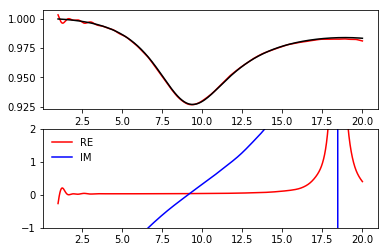

In [75]:
fig = plt.figure()
ax1, ax2 = fig.add_subplot(211), fig.add_subplot(212)
S11 = (data[0][:,1]+1j*data[0][:,2])*phase
ax1.plot(f/1e9, np.abs(S11), "r-", label="FDTD")
ax1.plot(f/1e9, np.abs((Zslab-377)/(Zslab+377)), "k-", label="analytic")
#ax1.set_ylim([0,1])
ax2.plot(f/1e9, np.real((1-S11)/(1+S11)), "r-", label="RE")
ax2.plot(f/1e9, np.imag((1-S11)/(1+S11)), "b-", label="IM")

ax2.set_ylim([-1,2])
ax2.legend(loc="best").draw_frame(False)
plt.show()

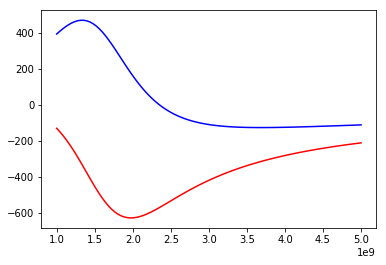

In [53]:
R = 9.9e-3
w = 1.5e-3
f = np.linspace(1,5,100)*1e9
S = lambda R, w, f: (377-Z(R,w,f)) / (377+Z(R,w,f))/7
plt.plot(f, np.real(Z(9.8e-3, 1.5e-3, f)),"r-")
plt.plot(f, np.imag(Z(9.8e-3, 1.5e-3, f)),"b-")

plt.show()

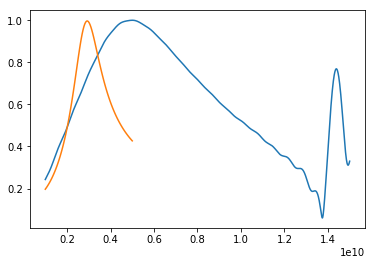

In [54]:
plt.plot(dat[:,0], np.abs(dat[:,1]+1j*dat[:,2]))
plt.plot(f, np.abs(S(9.8e-3, 1.5e-3, f)))
plt.show()

In [145]:
ks = np.unique([R.x for R in res ])

In [146]:
fs = 3e8*ks*1e3/(2*np.pi*np.sqrt(4.15))

In [147]:
fs

array([ -9.78325632e+13,  -9.63943920e+13,  -8.21721731e+13,
        -7.57833373e+13,  -5.19395600e+13,  -4.94771704e+13,
        -4.79938100e+13,  -4.31678669e+13,  -3.59737004e+13,
        -3.16971907e+13,  -2.84607542e+13,  -2.29602432e+13,
        -2.21686030e+13,  -2.17965595e+13,  -1.77186238e+13,
        -1.04768559e+12,  -9.45005259e+11,  -9.36637108e+11,
        -4.66835522e+11,  -4.56310376e+11,  -3.34110738e+11,
        -2.24040380e+11,  -2.13764319e+11,  -9.65446512e+10,
         1.00705507e+10,   1.00705726e+10,   1.00707088e+10,
         1.00707311e+10,   1.00707814e+10,   1.44034862e+10,
         1.44035228e+10,   1.44035539e+10,   1.44035585e+10,
         1.44035926e+10,   1.44037081e+10,   1.63421999e+10,
         1.20753664e+11,   1.20754614e+11,   1.20754823e+11,
         1.20755389e+11,   1.20755661e+11,   1.20756087e+11,
         1.20758141e+11,   1.20758256e+11,   1.20758590e+11,
         1.20758725e+11,   1.20758980e+11,   1.20759189e+11,
         1.20759194e+11,